Reproduce: SimPEG OcTree
=======================

## Inverting Pole-Dipole DC Resistivity Data over a Conductive and a Resistive Block

Here, we invert pole-dipole DC resistivity data collected over a conductive and a resistive block. We invert for a conductivity model using a least-squares inversion approach.

For the true model, the background conductivity $\sigma_0$ = 0.01 S/m. The conductor has a conductivity of $\sigma_c$ = 0.1 S/m and the resistor has a conductivity of $\sigma_r$ = 0.001 S/m. Both blocks are oriented along the Northing direction and have x, y and z dimensions of 400 m, 1600 m and 320 m. Both blocks are buried at a depth of 160 m.

The data being inverted were generated using the SimPEG OcTree code. Synthetic DC voltage data were simulated with a pole-dipole configuration. The survey consisted of 9 West-East survey lines, each with a length of 2000 m. The line spacing was 250 m and the electrode spacing was 100 m. Gaussian noise with a standard deviation of 1e-6 V + 5% the absolute value were added to each datum. Uncertainties of 1e-6 V + 5% were assigned to the data for inversion.

## SimPEG Package Details

**Link to the docstrings for the simulation class** The docstrings will have a citation and show the integral equation.

## Running the Inversion

We begin by importing all necessary Python packages for running the notebook.

In [1]:
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    plot_3d_pseudosection,
    apparent_resistivity,
    apparent_resistivity_from_voltage,
    convert_survey_3d_to_2d_lines
)
from SimPEG.utils.io_utils import read_dcipoctree_ubc, write_dcipoctree_ubc
from SimPEG import maps, data, data_misfit, regularization, optimization, inverse_problem, inversion, directives
from discretize import TreeMesh
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import numpy as np

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 14})
write_output = True

A compressed folder containing the assets required to run the notebook is then downloaded. This includes the mesh, true model, and observed data files.

In [2]:
# Import the .tar file

Extracted files are then loaded into the SimPEG framework.

In [3]:
rootdir = './../../../assets/dcip/block_model_dc_inv_simpeg_octree/'
meshfile = rootdir + 'octree_mesh.txt'
confile = rootdir + 'true_model.con'
dobsfile = rootdir + 'dobs_simpeg.txt'

mesh = TreeMesh.readUBC(meshfile)
true_conductivity_model = TreeMesh.readModelUBC(mesh, confile)
dc_data = read_dcipoctree_ubc(dobsfile, 'volt')

The observed data are measured voltages. And it is voltage data that are inverted. However, here we plot the observed data as apparent conductivities.

In [4]:
survey = dc_data.survey
apparent_conductivities = 1/apparent_resistivity_from_voltage(survey, dc_data.dobs, space_type="half space")

plane_points = []
for x in np.arange(-1000, 1100, 500):
    p1, p2, p3 = np.array([-1000.,x,0]), np.array([1000,x,0]), np.array([1000,x,-1000])
    plane_points.append([p1,p2,p3])

scene_camera=dict(
    center=dict(x=-0.1, y=0, z=-0.2), eye=dict(x=1.2, y=-1, z=1.5)
)
scene = dict(
    xaxis=dict(range=[-1000, 1000]), yaxis=dict(range=[-1000, 1000]), zaxis=dict(range=[-500, 0]),
    aspectratio=dict(x=1, y=1, z=0.5)
)

vlim = [apparent_conductivities.min(), apparent_conductivities.max()]
fig = plot_3d_pseudosection(
    dc_data.survey, apparent_conductivities, scale='log', vlim=vlim,
    plane_points=plane_points, plane_distance=10., units='S/m'
)
fig.update_layout(
    title_text="Apparent Conductivities", title_x=0.5, width=600, height=550, scene_camera=scene_camera, scene=scene
)
plotly.io.show(fig)

And here we plot the OcTree mesh used in the inversion. Since the topography is flat, all cells are active.

Text(0, 0.5, 'z (m)')

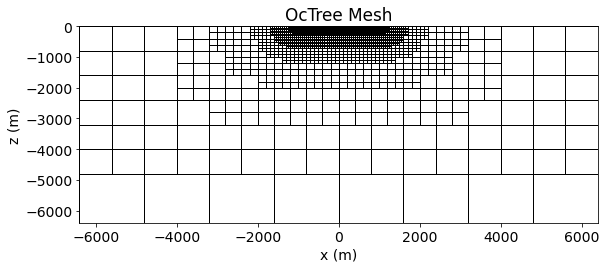

In [5]:
ind = int(len(mesh.hy)/2)
fig = plt.figure(figsize=(9, 3.5))
ax1 = fig.add_axes([0.1, 0.12, 0.8, 0.78])
zeros_array = np.zeros(mesh.nC)
mesh.plot_slice(
    zeros_array, ax=ax1, normal='Y', grid=True, ind=ind,
    pcolorOpts={"cmap": "binary"}
)
ax1.set_title("OcTree Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

Next, we define the mapping from the model space to the mesh and the simulation.

In [6]:
sig_map = maps.ExpMap()

simulation = dc.simulation.Simulation3DNodal(
    survey=survey,
    mesh=mesh,
    sigmaMap=sig_map,
    solver=Solver,
    bc_type='Neumann'
)

We now define a starting model for the inversion. We are inverting for the natural log of the conductivity. The starting model is defined based on a known background conductivity of 0.01 S/m.

In [7]:
m0 = np.log(1e-2*np.ones(mesh.nC))

Here we define the measure of data misfit, the regularization and the algorithm used to compute the step-direction at each iteration. These are used to define the inverse problem.

In [8]:
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

reg_map = maps.IdentityMap(nP=mesh.nC)

reg = regularization.Simple(
    mesh, mapping=reg_map,
    alpha_s=0.1, alpha_x=1., alpha_y=1., alpha_z=1.
)
reg.mrefInSmooth = True

opt = optimization.ProjectedGNCG(
    maxIter=10, maxIterLS=20, maxIterCG=30., tolCG=1e-3
)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

Here, we define the directives for the inversion.

In [9]:
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=20.)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)
target_misfit = directives.TargetMisfit(chifact=1)
sensitivity_weights = directives.UpdateSensitivityWeights(truncation_factor=0.005, threshold=0.)
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi
]

Finally, we define and run the inversion. Using our mapping, we convert the recovered model to the conductivity values defined on the mesh.

In [10]:
inv = inversion.BaseInversion(inv_prob, directives_list)
simpeg_model = inv.run(m0)

simpeg_model = sig_map*simpeg_model
dpred = inv_prob.dpred

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.10e+02  3.15e+04  0.00e+00  3.15e+04    1.26e+03      0              
   1  9.10e+02  2.90e+03  4.24e+00  6.76e+03    8.12e+01      0              
   2  4.55e+02  2.50e+03  4.59e+00  4.58e+03    9.64e+01      0   Skip BFGS  
   3  4.55e+02  1.34e+03  6.49e+00  4.30e+03    7.13e+00      0              
   4  2.28e+02  1.37e+03  6.43e+00  2.84e+03    6.66e+01      0              
   5  2.28e+02  7.09e+02  8.44e+00  2.63e+03    3.22e+00      0              
   6  1.14e+02  7.09e+02  8.45e+00  1.67e+03    4.23e+01  

If desired, we can output the recovered model and the predicted data.

In [11]:
if write_output:
    TreeMesh.writeModelUBC(mesh, rootdir+'recovered_model.con', simpeg_model)
    data_dpred = data.Data(survey=dc_data.survey, dobs=dpred)
    write_dcipoctree_ubc(rootdir+'dpred.txt', data_dpred, 'volt', 'dpred')

## Data Misfit Along a Single Survey Line

Here, we examine the data misfit by plotting a 2D pseudo-section for each survey line. We begin by parsing the 3D survey into a list of 2D surveys.

In [12]:
line_id = np.zeros(survey.nD)
northing = np.unique(survey.locations_a[:, 1])

for ii in range(0, len(northing)):
    line_id[survey.locations_a[:, 1] == northing[ii]] = ii

survey_2d_list = convert_survey_3d_to_2d_lines(survey, line_id, 'apparent_chargeability')

Next, we define the line ID (0-8) for the pole-dipole line we would like to examine. Then plot the observed data, predicted data and normalized misfit in 2D pseudosection.

D:\Documents\Repositories\simpeg\SimPEG\electromagnetics\static\utils\static_utils.py:578: UserWarning:

plot_pseudosection unused kwargs: {list(kwargs.keys())}



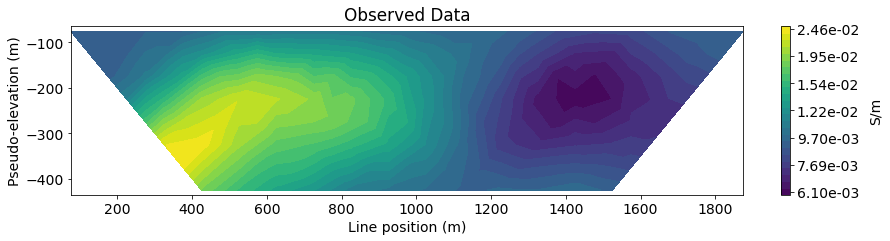

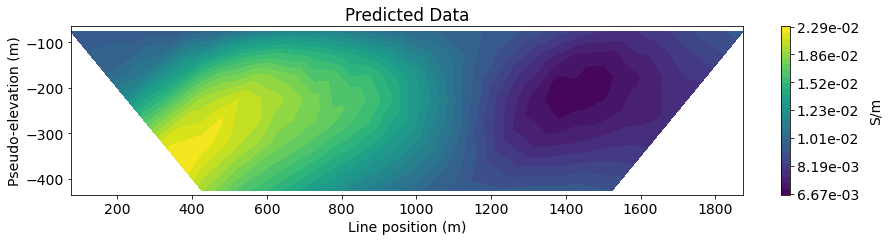

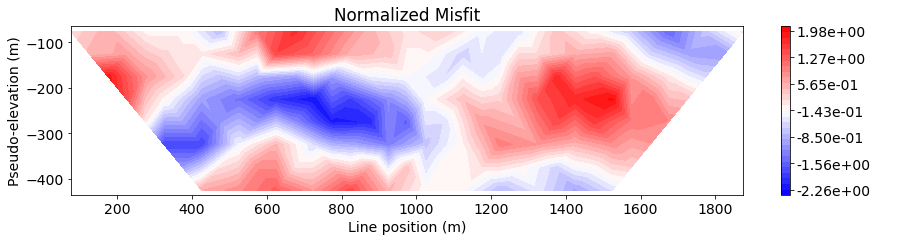

In [13]:
IND = 4
title_str = ['Observed Data', 'Predicted Data', 'Normalized Misfit']
data_list = [
    apparent_conductivities,
    1/apparent_resistivity_from_voltage(survey, dpred, space_type="half space"),
    (dc_data.dobs - dpred) / dc_data.standard_deviation
]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.bwr]
label_list = ["S/m", "S/m", " "]
scale_list = ['log', 'log', 'lin']

for ii in range(0, 3):

    fig = plt.figure(figsize=(14, 3))
    ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
    plot_pseudosection(
        survey_2d_list[IND],
        dobs=data_list[ii][line_id==IND],
        plot_type="contourf",
        ax=ax1,
        vlim=vlim,
        scale=scale_list[ii],
        cbar_label=label_list[ii],
        contourf_opts={"levels": 30, "cmap": cmap_list[ii]},
    )
    ax1.set_title(title_str[ii])
    plt.show()

## Comparing True and Recovered Models

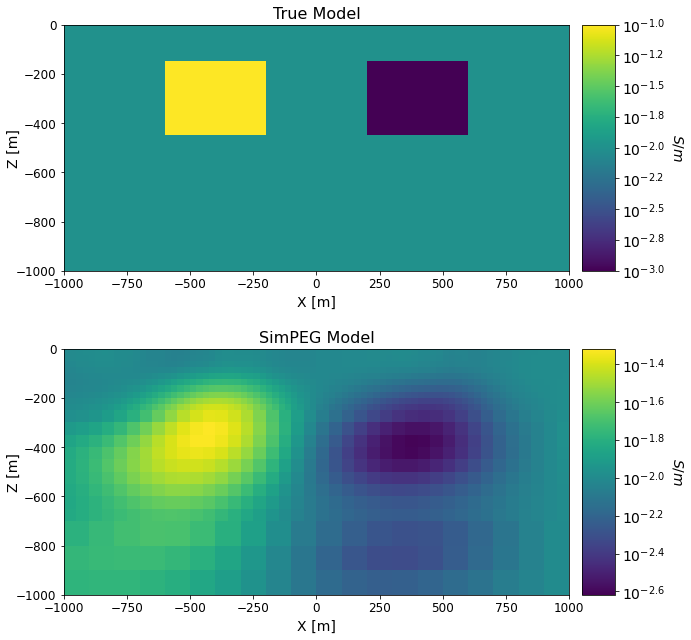

In [14]:
fig = plt.figure(figsize=(9, 9))
font_size = 14

models_list = [np.log10(true_conductivity_model), np.log10(simpeg_model)]
titles_list = ['True Model', 'SimPEG Model']
ax1 = 2*[None]
cplot = 2*[None]
ax2 = 2*[None]
cbar = 2*[None]

for qq in range(0, 2):
    ax1[qq] = fig.add_axes([0.1, 0.55 - 0.5*qq, 0.78, 0.38])
    
    cplot[qq] = mesh.plot_slice(
        models_list[qq], normal='Y', ind=int(len(mesh.hy)/2), grid=False, ax=ax1[qq]
    )
    cplot[qq][0].set_clim((np.min(models_list[qq]), np.max(models_list[qq])))
    ax1[qq].set_xlim([-1000, 1000])
    ax1[qq].set_ylim([-1000, 0])
    ax1[qq].set_xlabel("X [m]", fontsize=font_size)
    ax1[qq].set_ylabel("Z [m]", fontsize=font_size, labelpad=-5)
    ax1[qq].tick_params(labelsize=font_size - 2)
    ax1[qq].set_title(titles_list[qq], fontsize=font_size + 2)
    
    ax2[qq] = fig.add_axes([0.9, 0.55 - 0.5*qq, 0.05, 0.38])
    norm = mpl.colors.Normalize(vmin=np.min(models_list[qq]), vmax=np.max(models_list[qq]))
    cbar[qq] = mpl.colorbar.ColorbarBase(
        ax2[qq], norm=norm, orientation="vertical", format='$10^{%.1f}$'
    )
    cbar[qq].set_label(
        "$S/m$",
        rotation=270,
        labelpad=20,
        size=font_size,
)

plt.show()